# GPU computing with Numba (introduction)

François-David Collin (CNRS, IMAG, Paul-Valéry Montpellier 3
University)  
Ghislain Durif (CNRS, LBMC)  
Monday, August 26, 2024

> “[Numba](https://numba.pydata.org/) is an open source JIT compiler
> that translates a subset of Python and NumPy code into fast machine
> code.”

Numba offers GPU support (through CUDA). See the official
[documentation](https://numba.pydata.org/numba-doc/latest/cuda/index.html)
or this [NYU course](https://nyu-cds.github.io/python-numba/05-cuda/)

## Terminology

Several important terms in the topic of CUDA programming are listed
here:

-   host: the CPU along with the system memory (RAM)

-   device: the GPU

-   host memory: the system main memory

-   device memory: onboard memory on a GPU card

-   kernel: a GPU function launched by the host and executed on the
    device

-   device function: a GPU function executed on the device which can
    only be called from the device (i.e. from a kernel or another device
    function)

## First example: array reduction

In our examples: - 128 threads (on 64 CPU cores) to run CPU computing -
Nvidia A10 GPU to run GPU computing

|  |  |
|------------------------------------|------------------------------------|
| FP32 | 31.2 teraFLOPS |
| TF32 Tensor Core | 62.5 teraFLOPS |
| BFLOAT16 Tensor Core | 125 teraFLOPS |
| FP16 Tensor Core | 125 teraFLOPS |
| INT8 Tensor Core | 250 TOPS |
| INT4 Tensor Core | 500 TOPS |
| RT Core | 72 RT Cores |
| Encode/decode | 1 encoder2 decoder (+AV1 decode) |
| GPU memory | 24GB GDDR6 |
| GPU memory bandwidth | 600GB/s |
| Interconnect | PCIe Gen4 64GB/s |
| Form factors | Single-slot, full-height, full-length (FHFL) |
| Max thermal design power (TDP) | 150W |
| vGPU software support | NVIDIA Virtual PC, NVIDIA Virtual Applications, NVIDIA RTX Virtual Workstation, NVIDIA Virtual Compute Server, NVIDIA AI Enterprise |

A10 Technical Specifications and Features

### requirements

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
# import matplotlib.pyplot as plt

from numba import cuda, set_num_threads
import plotly.io as pio
pio.renderers.default = "notebook+plotly_mimetype+svg"

set_num_threads(128)
from numba.core.errors import NumbaPerformanceWarning
import warnings

warnings.simplefilter('ignore', category=NumbaPerformanceWarning)

### Reduction algorithm

In [2]:
@cuda.reduce
def sum_reduce(a, b):
    return a + b

**Attention**: the first call to `sum_reduce` will trigger a compilation
step so with Numba operators, we always need to run a blank run first
(on small data to avoid high computation time).

In [3]:
# blank run
A = np.arange(1,10).astype(np.float32)
sum_reduce(A)

### Toy example

In [4]:
# generate a vector array of dimension 1E7 with random float32 elements
A = np.random.normal(loc=0, scale=10, size=1000000).astype(np.float32)

In [5]:
# numpy sum reduction
t1 = %timeit -r 5 -n 800 -q -o A.sum()

In [6]:
sum_reduce(A)
# cuda sum reduction
t2 = %timeit -r 5 -n 800 -q -o sum_reduce(A)

#### Which one is faster ?

In [7]:
# numpy sum reduction
t1

In [8]:
# cuda sum reduction
t2

#### The GPU is slower????

### Benchmark numpy array sum vs cuda sum reduction

In [9]:
def benchmark1(N):
    A = np.random.normal(loc=0, scale=10, size=N).astype(np.float32)
    # numpy sum reduction
    t1 = %timeit -r 5 -n 10 -q -o A.sum()
    # cuda sum reduction
    t2 = %timeit -r 5 -n 10 -q -o sum_reduce(A)
    # output
    return t1.average, t2.average

#### Checking increasing vector size

In [10]:
# Powers of 2 vector
vec_size = [2**exp for exp in range(12,28)]

In [11]:
# check the list size candidates
import plotly.express as px

px.scatter(y=vec_size,width=600,labels={'y':"Data length",'x':"Vector index"},log_y=True)

#### Run the benchmark

In [12]:
# run the benchmark
from tqdm.notebook import tqdm

res = []

for N in tqdm(vec_size):
    
    time_res = benchmark1(N)
    
    res.append({
        'N': N,
        'numpy': time_res[0],
        'cuda': time_res[1]
    })

#### Results

In [13]:
df_res = pd.DataFrame(res)
px.line(df_res, x='N', y=['numpy', 'cuda'], log_y=True, log_x=True, width=600)

**It is confirmed!!! Why bother using GPU???**

#### Any idea ?

### Bottleneck

-   Host to device (GPU) memory copy

### Solution

-   Copy data to device (GPU) before running the computations

See Numba dedicated
[page](https://numba.pydata.org/numba-doc/latest/cuda/memory.html) for
memory management.

In [14]:
def benchmark2(N):
    print(f"sum of {N} elements")
    A = np.random.normal(loc=0, scale=10, size=N).astype(np.float32)
    # numpy sum reduction
    t1 = %timeit -r 5 -n 10 -q -o A.sum()
    # copy data to device
    A_gpu = cuda.to_device(A)
    # cuda sum reduction
    t2 = %timeit -r 5 -n 10 -q -o sum_reduce(A_gpu)
    # output
    return t1.average, t2.average

In [15]:
# run the benchmark
res = []

for N in tqdm(vec_size):
    
    time_res = benchmark2(N)
    
    res.append({
        'N': N,
        'numpy': time_res[0],
        'cuda': time_res[1]
    })

In [16]:
# results
df_res2 = pd.DataFrame(res)
px.line(df_res2, x='N', y=['numpy', 'cuda'], log_y=True, log_x=True, width=600)

**GPU is better to do high throughput computing with larger matrices.**

### GPU memory overflow

In [17]:
try:
    A = np.random.normal(loc=0, scale=10, size=int(2E9)).astype(np.float32)
    sum_reduce(A)
except Exception as e:
    print(e)

**To avoid memory overflow:** -
[KeOps](https://www.kernel-operations.io/keops/index.html): Kernel
Operations (including matrix operations and reduction) on the GPU, with
autodiff, without memory overflows

In [18]:
# Note: CPU memory overflow
try:
    A = np.random.normal(loc=0, scale=10, size=int(1E12)).astype(np.float32)
    sum_reduce(A)
except Exception as e:
    print(e)

### Complex operation on GPU ?

$$\sum_i \vert x_i \vert = \sum_i (-1)^{I_{\{x_i < 0\}}} x_i = \sum_{i,x_i \geq 0} x_i - \sum_{i,x_i < 0} x_i$$

Example: if $x = [-1, 3, 5, -2]$ then we want to compute $1 + 3 + 5 + 2$

In [19]:
# Numpy reduce
def numpy_reduce(vec):
    return (vec * np.where(vec < 0, -1, 1)).sum()

# numba cpu reduce
from numba import njit, prange, set_num_threads

set_num_threads(8)

@njit(parallel=True)
def numba_reduce(A):
    s = 0
    # Without "parallel=True" in the jit-decorator
    # the prange statement is equivalent to range
    for i in prange(A.shape[0]):
        if A[i] < 0:
            s += -A[i]
        else:
            s += A[i]
    return s

# cuda reduce
@cuda.reduce
def cuda_reduce(a, b):
    if b < 0:
        return a - b
    else:
        return a + b
    
A = np.random.normal(loc=0, scale=10, size=1000).astype(np.float32)
numba_reduce(A)
cuda_reduce(A)

In [20]:
# benchmark
def benchmark3(N):
    print(f"complex operations on {N} elements")
    A = np.random.normal(loc=0, scale=10, size=N).astype(np.float32)
    # numpy reduction
    t1 = %timeit -r 2 -n 5 -q -o numpy_reduce(A)
    # numba reduction
    t2 = %timeit -r 2 -n 5 -q -o numba_reduce(A)
    # cuda reduction
    A_gpu = cuda.to_device(A)
    t3 = %timeit -r 2 -n 5 -q -o cuda_reduce(A_gpu)
    # output
    return t1.average, t2.average, t3.average

In [21]:
# run the benchmark
res = []
resspeedup = []
for N in tqdm(vec_size):
    
    time_res = benchmark3(N)
    
    res.append({
        'N': N,
        'numpy': time_res[0],
        'numba_128c': time_res[1],
        'cuda': time_res[2],
    })
    resspeedup.append({
        'N': N,
        'numpy/numba': time_res[0]/time_res[1],
        'numpy/cuda': time_res[0]/time_res[2]
    })

In [22]:
# results
df_res = pd.DataFrame(res)
fig = px.line(df_res, x='N', y=['numpy', 'numba_128c', 'cuda'], log_y=True, log_x=True, width=600)
fig.show()
df_resspeedup = pd.DataFrame(resspeedup)
fig = px.line(df_resspeedup, x='N', y=['numpy/numba', 'numpy/cuda'], log_y=True, log_x=True, width=600)
fig.show()

## Numba for GPU: next level

### GPU management

In [23]:
# to check available GPU
from numba import cuda
for gpu in cuda.list_devices():
    print(gpu.name)
    
cuda.get_current_device().name

### Kernel declaration

kernel function = GPU function meant to be called from CPU code

Characteristics: - kernels **cannot explicitly return a value** (all
result data must be written to an array passed to the function) -
kernels **explicitly declare their thread hierarchy when called**:
i.e. the number of thread blocks and the number of threads per block

**Attention**: Kernel function are compiled on their first call, we
always need to run a blank run first (on small data to avoid high
computation time).

In [24]:
from numba import cuda

@cuda.jit
def my_kernel(io_array):
    """
    Code for kernel.
    """
    # code here

In [25]:
import numpy

# Create the data array - usually initialized some other way
data = numpy.ones(256)

# Set the number of threads in a block
threadsperblock = 32 

# Calculate the number of thread blocks in the grid
blockspergrid = (data.size + (threadsperblock - 1)) // threadsperblock

# Now start the kernel
my_kernel[blockspergrid, threadsperblock](data)

# Print the result
print(data)

**Important**: you have to choose the number of blocks per grid (and
hence the block size) and the number of threads per block. The product
of the two will give the total number of threads launched.

### Choosing the block size

[Credit](https://nyu-cds.github.io/python-numba/05-cuda/)

The two-level thread hierarchy is important for the following reasons:

-   On the software side, the block size determines how many threads
    share a given area of shared memory.
-   On the hardware side, the block size must be large enough for full
    occupation of execution units; recommendations can be found in the
    CUDA C Programming Guide.

The block size you choose depends on a range of factors, including:

-   The size of the data array
-   The size of the shared mempory per block (e.g. 64KB)
-   The maximum number of threads per block supported by the hardware
    (e.g. 512 or 1024)
-   The maximum number of threads per multiprocessor (MP) (e.g. 2048)
-   The maximum number of blocks per MP (e.g. 32)
-   The number of threads that can be executed concurrently (a “warp”
    i.e. 32)

The execution of threads in a warp has a big effect on the computational
throughput. If all threads in a warp are executing the same instruction
then they can all be executed in parallel. But if one or more threads is
executing a different instruction, the warp has to be split into groups
of threads, and these groups execute serially.

**Rules of thumb for threads per block:**

-   Should be a round multiple of the warp size (32)
-   A good place to start is 128-512 but benchmarking is required to
    determine the optimal value.

Each streaming multiprocessor (SP) on the GPU must have enough active
warps to achieve maximum throughput. In other words, the blocksize is
usually selected to maximize the “occupancy”. See the [CUDA Occupancy
Calculator
spreadsheet](http://developer.download.nvidia.com/compute/cuda/CUDA_Occupancy_calculator.xls)for
more details.

### Thread positioning

[Credit](https://nyu-cds.github.io/python-numba/05-cuda/)

When running a kernel, the kernel function’s code is executed by every
thread once. It therefore has to know which thread it is in, in order to
know which array element(s) it is responsible for. More complex
algorithms may define more complex responsibilities, but the underlying
principle is the same.

To help deal with multi-dimensional arrays, CUDA allows you to specify
multi-dimensional blocks and grids. In the example above, you could make
blockspergrid and threadsperblock tuples of one, two or three integers.
Compared to 1-dimensional declarations of equivalent sizes, this doesn’t
change anything to the efficiency or behaviour of generated code, but
can help you write your algorithms in a more natural way.

### Matrix product

Numpy version for comparison

In [26]:
# numpy version
def numpy_matmul(A, B):
    C = np.matmul(A, B)
    return C

#### Naive cuda version

In [27]:
@cuda.jit
def cuda_matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

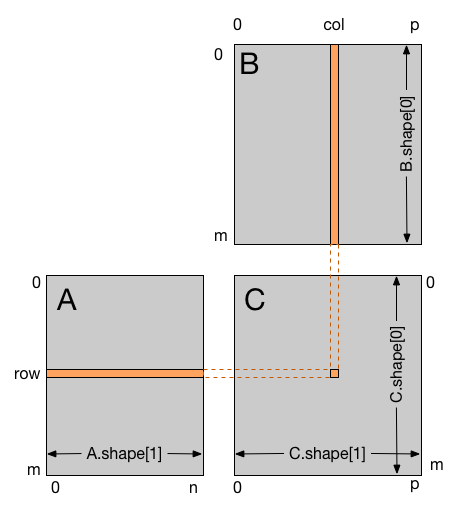
[Credit](https://nyu-cds.github.io/python-numba/05-cuda/)

#### Run

In [28]:
# data 1000x1000 matrix
A = np.random.normal(loc=0, scale=10, size=1000**2).astype(np.float32).reshape((1000,1000))
B = np.random.normal(loc=0, scale=10, size=1000**2).astype(np.float32).reshape((1000,1000))

In [29]:
# numpy run
%timeit -r 5 -n 20 -q -o numpy_matmul(A, B)

In [30]:
# Copy the arrays to the device
A_gpu = cuda.to_device(A)
B_gpu = cuda.to_device(B)

# Allocate memory on the device for the result
C_gpu = cuda.device_array((24, 22))

In [31]:
# Configure the blocks
import math
threadsperblock = (16, 16)
blockspergrid_x = int(math.ceil(A.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(B.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

In [32]:
#
# CUDA matrix multiplication
#
@cuda.jit
def cuda_matmul1(A, B, C):
    """Perform square matrix multiplication of C = A * B
    """
    i, j = cuda.grid(2)
    if i < C.shape[0] and j < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[i, k] * B[k, j]
        C[i, j] = tmp

In [33]:
# cuda run
%timeit -r 5 -n 20 -q -o cuda_matmul1[blockspergrid, threadsperblock](A_gpu, B_gpu, C_gpu)

In [34]:
# get the result from the GPU
C = C_gpu.copy_to_host()

In [35]:
from numba import cuda, float32

# Controls threads per block and shared memory usage.
# The computation will be done on blocks of TPBxTPB elements.
TPB = 16

@cuda.jit
def cuda_fast_matmul(A, B, C):
    # Define an array in the shared memory
    # The size and type of the arrays must be known at compile time
    sA = cuda.shared.array(shape=(TPB, TPB), dtype=float32)
    sB = cuda.shared.array(shape=(TPB, TPB), dtype=float32)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bpg = cuda.gridDim.x    # blocks per grid

    if x >= C.shape[0] and y >= C.shape[1]:
        # Quit if (x, y) is outside of valid C boundary
        return

    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of TPB-long vectors.
    tmp = 0.
    for i in range(bpg):
        # Preload data into shared memory
        sA[tx, ty] = A[x, ty + i * TPB]
        sB[tx, ty] = B[tx + i * TPB, y]

        # Wait until all threads finish preloading
        cuda.syncthreads()

        # Computes partial product on the shared memory
        for j in range(TPB):
            tmp += sA[tx, j] * sB[j, ty]

        # Wait until all threads finish computing
        cuda.syncthreads()

    C[x, y] = tmp

In [36]:
# Configure the blocks
threadsperblock = (TPB, TPB)
blockspergrid_x = int(math.ceil(A.shape[0] / threadsperblock[1]))
blockspergrid_y = int(math.ceil(B.shape[1] / threadsperblock[0]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

# Start the kernel 
%timeit -r 5 -n 20 -q -o cuda_fast_matmul[blockspergrid, threadsperblock](A_gpu, B_gpu, C_gpu)